In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import GA_lib as GA
import copy
from  GA_lib import data_sampled
from  GA_lib import dag_true
import bnlearn as bn
from pgmpy.estimators import ParameterEstimator, BicScore
from pgmpy.models import BayesianNetwork
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import classification_report

In [2]:
#my_dict

In [3]:
# Number of samples 
#column_indices = np.random.permutation(data.columns)
#N_samples=5000
#data_sampled=data.sample(N_samples)
#data_sampled=data_sampled.astype('category')
#data_sampled = data_sampled[column_indices]
#data_sampled.columns

In [4]:

# Read the CSV file into a DataFrame
df = dag_true
# Define the desired topological order
topological_order =list(data_sampled.columns)

# Create a list of unique variables (nodes)
nodes = np.unique(df[['Variable 1', 'Variable 2']].values)

# Initialize an empty adjacency matrix filled with zeros
num_nodes = len(nodes)
adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

# Iterate through the DataFrame and update the adjacency matrix based on dependencies
for _, row in df.iterrows():
    var1 = row['Variable 1']
    var2 = row['Variable 2']
    dependency = row['Dependency']

    # Find the indices of var1 and var2 in the topological order list
    index1 = topological_order.index(var1)
    index2 = topological_order.index(var2)

    # Set the corresponding entry in the adjacency matrix to 1
    if dependency == '->':
        adjacency_matrix[index1, index2] = 1

print("Adjacency Matrix (in topological order):")
print(adjacency_matrix)

Adjacency Matrix (in topological order):
[[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0]]


In [5]:
def otimizador_func(obj):
    obj.evaluate_cost()
    obj_old_cost=obj.cost
    # Deep copy (new copies of all objects referenced within obj)
    obj_old_deep = copy.deepcopy(obj)
    #obj_old=obj
    obj.mutate()
    obj.evaluate_cost()
    i=0
    while(i<obj.adjacency_matrix.shape[0]):


        #print("obj_old_cost :", obj_old_cost)
        #print("obj_old_deep.cost :", obj_old_deep.cost)
        #print("obj.cost   :", obj.cost)

        if(obj.cost>obj_old_cost):
            obj_old_deep = copy.deepcopy(obj)
            obj_old_cost=obj_old_deep.cost
            #print("Entrei")
        else:
            obj=copy.deepcopy(obj_old_deep)
            obj.mutate()
            obj.evaluate_cost()
            #print("nao entrei")
        i=i+1
        
        



    #print("obj_old_deep:", obj_old_deep.cost)
    #print("custo atual :", obj.cost)
    return obj_old_deep

In [6]:
n=adjacency_matrix.shape[0]
mask=np.triu(np.ones([n,n]), k=1)
rows, cols = np.where(mask)
index = np.array([rows, cols]).T

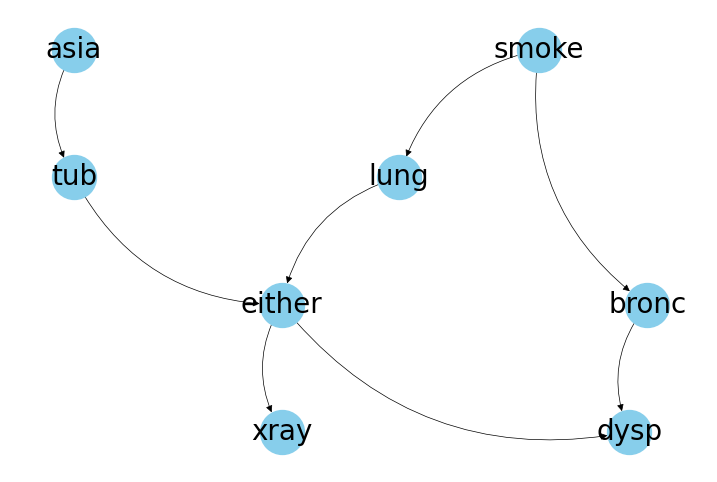

In [7]:
#GA.plot_digraph(sorted_people[0].adjacency_matrix,data_sampled.columns)

GA.plot_digraph(adjacency_matrix,data_sampled.columns)

In [8]:
from line_profiler import LineProfiler

In [9]:
def GA_body():

    ### GA body 
    best_fit=[]
    max_interations=3000
    stability_threshold=500
    prev_best_cost=0
    j=0
    pc=0.5
    pm=0.5
    po=0.1
    n_pais=8
    stable_count=1
    initial_pop=300
    #######################################################################################################################################
    #Creating initial population

    # Define the probabilities vector
    n=adjacency_matrix.shape[0]
    vector_length = int(n*(n-1)*0.5)
    probabilities = [1/vector_length, (vector_length-2)/vector_length, 1/vector_length]
    Pop_size = np.array(range(initial_pop))
    ##

    object_list = []
    for i in range(initial_pop):
        vector = np.random.choice([-1, 0, 1], size=vector_length, p=probabilities)
        obj=GA.BayesianNetworkIndividual.from_bit_representation(vector,data_sampled,index=index)
        cost=obj.evaluate_cost()
        #print(cost)
        object_list.append(obj)
        
    sorted_people = sorted(object_list, key=lambda obj:obj.cost,reverse = True)

    while(True):
        
    #for j in range(max_interations):
        # parents selection
        parents=[]
        for i in range(n_pais):
            # selection by tourment assuming and order vector just return the smallest index drawed
            selected_torneio=np.random.choice(Pop_size, size=1, replace=False)
            parents.append(copy.deepcopy(sorted_people[selected_torneio[0]]))

        # Crossover
        filhos=[]
        for i in  range(0, n_pais, int(2)):
            if(pc>np.random.rand()):
                #parents[i]=otimizador_func(parents[i])
                f1,f2 =parents[i].crossover(parents[i+1])
                filhos.extend(copy.deepcopy([f1,f2]))
            else:
                filhos.extend(copy.deepcopy([parents[i],parents[i+1]]))

        # Mutation & cost evaluation
        for i in range(n_pais):
            if(pm>np.random.rand()):
                filhos[i].mutate()
            filhos[i].evaluate_cost()
        
        if(po>np.random.rand()):
                inx=np.random.choice(n_pais,1)[0]
                filhos[inx]=otimizador_func(filhos[inx])

        # Sorting acording to cost function 
        sorted_people.extend(filhos)
        sorted_people = sorted(sorted_people, key=lambda obj:obj.cost,reverse = True)
        #po=po*1.00231
        
        #print(po)
        for _ in range(n_pais):
            sorted_people.pop()

        best_fit.append(sorted_people[0].cost)
        # Check for stability
        #print("prev_best_cost", prev_best_cost)
        #print("best_fit[j]", best_fit[j])
        if best_fit[j] == prev_best_cost:
                stable_count += 1
                #print("stable_count", stable_count)
                
        else:
                stable_count =0
        
        if stable_count >= stability_threshold:
                print(f"Stopping criterion met: Cost has been stable for {stability_threshold} generations.")
                break
        if j >= max_interations:
                print("Maximum number of iterations reached.")
                break
        #print("Stable count", stable_count)
        #print("prev_best_cost ", prev_best_cost)
        prev_best_cost=copy.deepcopy(sorted_people[0].cost)
        #prev_best_cost=(sorted_people[0].cost)
        j=j+1
    return sorted_people,best_fit

In [16]:
true_labels = adjacency_matrix.flatten()
f1_scores_1 = []  # List to store F1 scores for class 1
f1_scores_0 = []  # List to store F1 scores for class 0

for k in range(1):
    sorted_people, best_fit = GA_body()

    # Reshape the matrices into 1-D arrays
    predicted_labels = sorted_people[0].adjacency_matrix.flatten()

    # Calculate the F1 score between the vectors
    f1_1 = f1_score(true_labels, predicted_labels)
    f1_0 = f1_score(1 * (true_labels == 0), 1 * (predicted_labels == 0))

    # Append the F1 scores to the respective lists
    f1_scores_1.append(f1_1)
    f1_scores_0.append(f1_0)

    # Calculate the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)
    
    print(f"Run {k + 1}:")
    print(f"Cost best: {sorted_people[0].cost}")
    print(f"F1 1 Score: {f1_1}")
    print(f"F1 0 Score: {f1_0}")

# Calculate and print the average F1 scores
avg_f1_1 = sum(f1_scores_1) / len(f1_scores_1)
avg_f1_0 = sum(f1_scores_0) / len(f1_scores_0)
print("\nAverage F1 1 Score:", avg_f1_1)
print("Average F1 0 Score:", avg_f1_0)


Stopping criterion met: Cost has been stable for 500 generations.
Run 1:
Cost best: -11276.080838142749
F1 1 Score: 0.75
F1 0 Score: 0.9642857142857143
Stopping criterion met: Cost has been stable for 500 generations.
Run 2:
Cost best: -11276.080838142749
F1 1 Score: 1.0
F1 0 Score: 1.0

Average F1 1 Score: 0.875
Average F1 0 Score: 0.9821428571428572


In [ ]:
#import cProfile


#profilie_GA=cProfile.run("GA_body()", sort="ncalls")
#best_fit, sorted_people=GA_body()

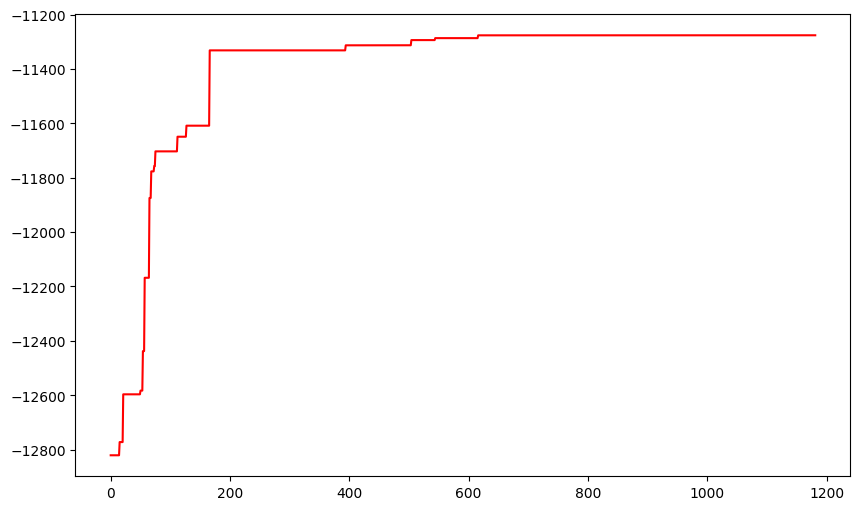

In [13]:
# Create a time array for the x-axis
interacoes = np.arange(0, len(best_fit))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(interacoes, best_fit, label='best_fit', color='red')

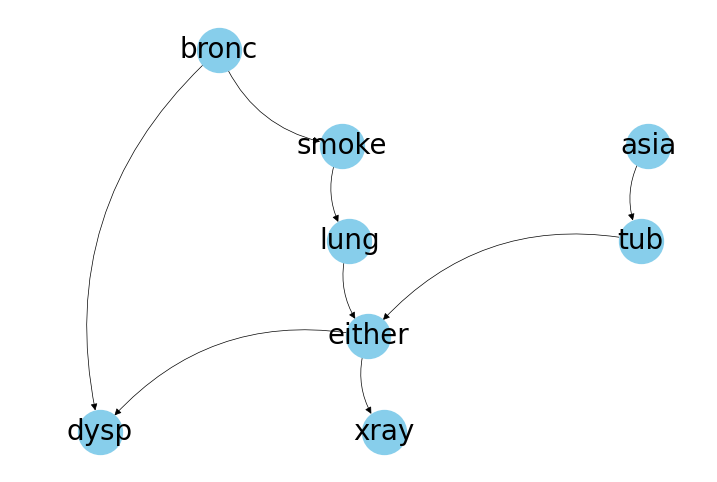

-11276.080838142749

In [14]:
GA.plot_digraph(sorted_people[0].adjacency_matrix,data_sampled.columns)
sorted_people[0].cost

In [15]:


edges_model=pd.DataFrame()
edges_model_sl=pd.DataFrame()
node_names = np.array(data_sampled.columns)
model = BayesianNetwork()
model.add_nodes_from(node_names)
for i in range(len(node_names)):
    for j in range(len(node_names)):
        if adjacency_matrix[i][j] == 1:
            model.add_edge(node_names[i], node_names[j])
            edges_model = edges_model.append({'source': node_names[i], 'target': node_names[j]}, ignore_index=True)


edges_model_sl=pd.DataFrame()
model_sl = BayesianNetwork()
model_sl.add_nodes_from(node_names)
for i in range(len(node_names)):
    for j in range(len(node_names)):
        if sorted_people[0].adjacency_matrix[i][j] == 1:
            model_sl.add_edge(node_names[i], node_names[j])
            edges_model_sl = edges_model_sl.append({'source': node_names[i], 'target': node_names[j]}, ignore_index=True)



pe = ParameterEstimator(model, data_sampled)
bic = BicScore(data_sampled)
bic_score=bic.score(model)
print("BIC Score:", bic_score)

BIC Score: -11276.080838142761


In [ ]:

# Reshape the matrices into 1-D arrays
true_labels = adjacency_matrix.flatten()
predicted_labels = sorted_people[0].adjacency_matrix.flatten()

# Calculate the F1 score between the vectors
f1_1 = f1_score(true_labels, predicted_labels)
f1_0 = f1_score(1*(true_labels==0), 1*(predicted_labels==0))
# Calculate the confusion matrix
#confusion = confusion_matrix(1*(true_labels==0), 1*(true_labels==0))

confusion = confusion_matrix(true_labels,predicted_labels)

print(f"F1 1 Score: {f1_1}")
print(f"F1 0 Score: {f1_0}")
#print("Confusion Matrix:" ,confusion)
# Generate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report summary
print("Classification Report:\n", report)



In [ ]:


ground=GA.BayesianNetworkIndividual(adjacency_matrix,data_sampled)
ground.evaluate_cost()
ground.cost

In [ ]:
# plot ground truth

model_sl = bn.make_DAG(model_sl)
model = bn.make_DAG(model)
G = bn.plot(model)

retunr_type=bn.compare_networks(model, model_sl,figsize=(30, 16))


#GA.plot_digraph(adjacency_matrix,data_sampled.columns)

In [ ]:
confusion_matrix=retunr_type[0]


# Assign values to variables
TP = confusion_matrix[1][1]  # True Positives
FP = confusion_matrix[0][1]  # False Positives
FN = confusion_matrix[1][0]  # False Negatives
TN = confusion_matrix[0][0]  # True Negatives

# Calculate Precision, Recall, and F1 Score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 score : {f1_score}")